# Ice Diagnostics

In [30]:
from glob import glob
import os
import xarray as xr
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature
%matplotlib inline
from IPython.display import HTML

In [2]:
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [4]:
DataDir = '/g/data3/hh5/tmp/cosima/mom01v5'
expt = 'KDS75'

In [5]:
expdir = os.path.join(DataDir, expt)
dataFileList = glob(os.path.join(expdir, 'output*/ice_month.nc'))
dataFileList.sort()

In [20]:
gridFileList = glob(os.path.join(expdir, 'output*/ocean_grid.nc'))
gridFileList.sort()

In [26]:
dsx_grid = xr.open_dataset(gridFileList[0], decode_times=False)
area_t = dsx_grid.area_t

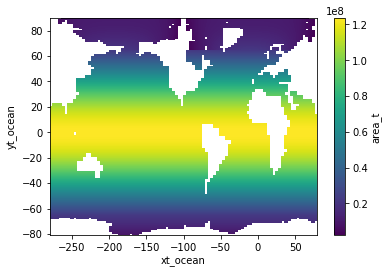

In [34]:
dsx_grid.area_t.plot()

From `diag_table`


Saved in `ice_month.nc`

CN, HI, HS
averaged globally over each month


In [6]:
dsx = xr.open_mfdataset(dataFileList[:12], decode_times=False, concat_dim='time')

There is an outstanding issue with year outside of a given range.  Artificially shift the years to years since 2000.

In [7]:
dsx.time.attrs['units'] = 'days since 2000-01-01 00:00:00'
dsx.average_T1.attrs['units'] = 'days since 2000-01-01 00:00:00'
dsx.average_T2.attrs['units'] = 'days since 2000-01-01 00:00:00'
dsx = xr.decode_cf(dsx)

Annual ice volume

In [61]:
HI = dsx.sel(yt=slice(-90, -60)).HI
south_area_t = area_t.sel(yt_ocean=slice(-90,-60))
HI

<xarray.DataArray 'HI' (time: 72, yt: 490, xt: 3600)>
[127008000 values with dtype=float64]
Coordinates:
  * xt       (xt) float64 -280.0 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yt       (yt) float64 -81.11 -81.07 -81.02 -80.98 -80.94 -80.9 -80.86 ...
  * time     (time) datetime64[ns] 2010-02-15 2010-03-16T12:00:00 2010-04-16 ...
Attributes:
    long_name: ice thickness
    units: m-ice
    cell_methods: time: mean
    time_avg_info: average_T1,average_T2,average_DT

In [62]:
volume = south_area_t.values * HI
volume.name = 'Volume'

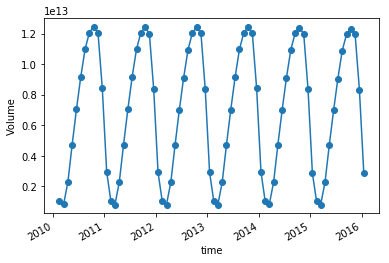

In [63]:
volume.sum(dim='yt').sum(dim='xt').plot(marker='o')

In [12]:
import matplotlib as mpl
from matplotlib import rc

rc('animation', ffmpeg_path='/short/v45/jm0634/conda/envs/my_analysis3/bin/ffmpeg')
rc('animation', html='html5')

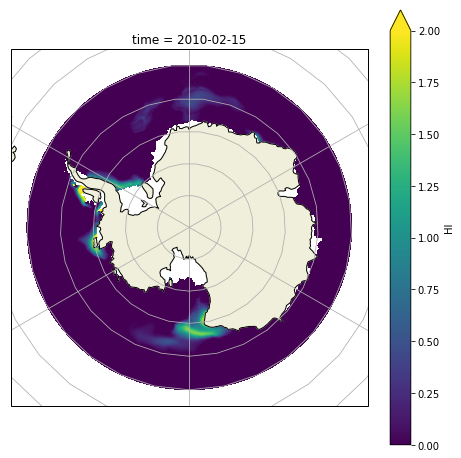

In [9]:
plt.figure(figsize=[8,8])
ax1 = plt.subplot(1,1,1, projection=ccrs.SouthPolarStereo())
#ax1.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND)
#ax1.add_feature(cartopy.feature.OCEAN)
ax1.coastlines()
#ax1.stock_img()
ax1.gridlines()

quadmesh = dsx.HI.isel(time=0)\
            .sel(yt=slice(-90, -60))\
            .plot\
            .pcolormesh(ax=ax1, 
                        transform=ccrs.PlateCarree(),
                        vmax=2)

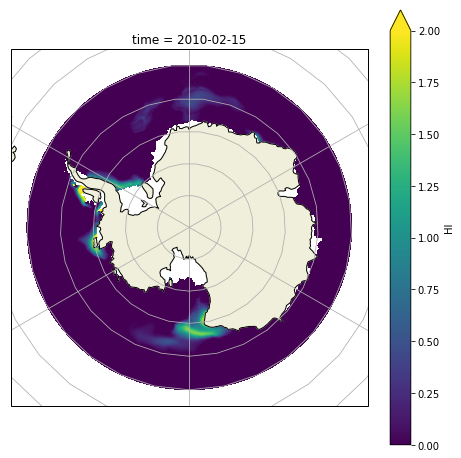

In [17]:
import matplotlib.animation as animation

fig = plt.figure(figsize=[8,8])

ax1 = plt.subplot(1,1,1, projection=ccrs.SouthPolarStereo())
#ax1.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND)
#ax1.add_feature(cartopy.feature.OCEAN)
ax1.coastlines()
#ax1.stock_img()
ax1.gridlines()

quadmesh = dsx.HI.isel(time=0).sel(yt=slice(-90, 
                                 -60)).plot(ax=ax1, 
                                            transform=ccrs.PlateCarree(),
                                            vmax=2)
def animate(i):
    print(i)
    da = dsx.HI.isel(time=i).sel(yt=slice(-90,-60))
    quadmesh.set_array(da.to_masked_array().ravel())
    ax1.set_title('time = {}'.format(da.time.values))
    return quadmesh, ax1.title

def init_func():
    return quadmesh,

In [18]:
ani = animation.FuncAnimation(fig, animate, 6, 
                              init_func=init_func,
                              interval=1000, blit=True, repeat_delay=3000)

In [19]:
ani

0
1
2
3
4
5
